# **BDTs at work: the $\mathrm{D}^{+}_{s}$ analysis**

The goal of this tutorial is to train and test a multi-class classification algorithm. The tutorial focuses on the measurement of the $\mathrm{D}^{+}_{s}$ meson in pp collisions with the data collected by ALICE in the first year of Run 3. 

The $\mathrm{D}^{+}_{s}$ meson is reconstructed in its hadronic decay channel $\mathrm{D}^{+}_{s} \rightarrow \mathrm{\phi} + \pi^+ + K^+ + K^- + \pi^-$. The $\mathrm{D}^{+}_{s}$ mesons are typically categorised as either _prompt_ (i.e. originating from charm quark hadronisation) or _non-prompt_ (i.e. originating from beauty-hadron decay). In this tutorial both these classes are considered. In particular, the ML algorithm is going to classify the $\mathrm{D}^{+}_{s}$ meson candidates as: prompt, non-prompt, or background.

To this end we need to train the ML algorithm with examples from all the three classes. For the signal we will use MC simulations, while for the background we will use the data collected in pp collisions by ALICE in Run 3.
In particular:
- MC production: _LHC22b1b_ (charm-enriched), _LHC22b1a_ (beauty-enriched)
- Data: _LHC22o_pass4_

<img src="img/DsDecaySketch.png" 
     align="center" 
     width="900" />

### **File download**

The first step is to download all the samples we will need for the ML training and test. In Run 3, the tables produced by the analysis workflows in O2Physics can be saved locally as derived data or via _TreeCreator_ tasks in the form of Trees. This format is easier to be handled by the ML model. 

To spare time, the AO2D from hyperloop have been filtered and organised in .parquet files. However, the Tree format can be employed as well following the same procedure presented below.

In [1]:
!curl -L https://cernbox.cern.ch/s/ZDAodCh7HsDwTRL/download --output promptDs.parquet
!curl -L https://cernbox.cern.ch/s/gghRd33rt4JeJ48/download --output nonpromptDs.parquet
!curl -L https://cernbox.cern.ch/s/ZujI6AZkMZCB9Jg/download --output Data.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 24.9M    0 24.9M    0     0  5695k      0 --:--:--  0:00:04 --:--:-- 7783k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 74.7M    0 74.7M    0     0  8960k      0 --:--:--  0:00:08 --:--:-- 11.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  513M    0  513M    0     0   9.9M      0 --:--:--  0:00:51 --:--:-- 11.0M:--  0:00:03 --:--:--     0


## Boosted Decision Tree in a nutshell

Supervised learning, a well-established subfield within the realm of Machine Learning, holds significant relevance in High Energy Physics (HEP). In this context, supervised learning techniques are instrumental to solve classification problems.

The process begins with a training set, comprising a set of examples. Each element of this training set is assigned a label indicating its class. In the physics case under study: prompt, non-prompt, or background. In the training the class information is known in advance. The training process focuses on optimising the internal parameters of the ML algorithm to maximise the separation power between the classes. 

The primary objective of the training is to impart the model with common data patterns that can be exploited for accurately classify an independent sample, the data collected by ALICE for instance. The supervised model associates to each candidate an _outputscore_, which depends on the properties of the candidate itself, referred to as _features_. The score is linked to the probability of the candidate belonging to one of the different classes.

In this tutorial, _Boosted Decision Trees_ (BDTs) are employed to tag prompt and non-prompt $\mathrm{D}^{+}_{s}$ candidates. The building block of every BDT model is the _Decision Tree_ algorithm (DT). A decision tree is a binary structure that resembles a flowchart. In this structure, internal nodes represent features or candidates, branches indicate decision rules, and leaf nodes represent the final outcomes. The DT operates by employing a sequence of simple binary tests, each corresponding to a branch in the tree, to classify a data point based on its features. These tests involve applying a linear threshold to one of the features, aiding the model in predicting the class to which every candidate belongs. 

Training a decision tree involves an automated process that recursively constructs the tree using the training set. However, a key limitation of decision trees is their susceptibility to _overfitting_. This means that, if a decision tree is deep enough (where depth is defined as the length of the longest path from the root to a leaf), it can perfectly classify the training set but may struggle to generalise to new data. Overfitting occurs when the model essentially "memorises" the training set rather than learning more general patterns in data. To mitigate this issue, BDT algorithms are employed, which combine multiple shallow trees, each using a subset of features. In the boosting procedure, decision trees are constructed sequentially, with an emphasis on compensating for misclassified candidates from the previous trees. The resulting model, the BDT, maintains strong performance on both the training and test sets.

### **Required python packages**

We first import standard _python packages_ that will be used later on (mainly for plotting)

In [2]:
### standard sci-py libraries
import matplotlib.pyplot as plt

Then, we import the [hipe4ml](https://github.com/hipe4ml/hipe4ml) package.


<img src="img/hipe4ml.png" 
     align="center" 
     width="300" />

This package developed in ALICE contains useful methods and classes for dealing with ML analyses.
Two main classes are implemented:
- _TreeHandler_, wrapping uproot and pandas methods: allows for conversion and handling of the training samples (for more info about pandas and uproot have a look here);
- _ModelHandler_, a common interface for many ML methods;
- _plot_utils_, containing a list of plotting methods to visualize the outcome of the ML analyses.
- _analysis_utils_, containing useful analysis functions

In [3]:
import xgboost as xgb
from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import plot_utils
from hipe4ml.analysis_utils import train_test_generator, bdt_efficiency_array

/home/spolitan/user_python/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Preparing the training set and the test set**

We now open the parquet with the _TreeHandler_ class to facilitate the handling of the data for ML purposes.  

In [19]:
hdl_mc_prompt = TreeHandler("promptDs.parquet")
hdl_mc_nonprompt = TreeHandler("nonpromptDs.parquet")
hdl_data = TreeHandler("Data.parquet")

# Preselections (consideing just one pt bin)
hdl_mc_prompt.apply_preselections("2 < fPt < 4")
hdl_mc_nonprompt.apply_preselections("2 < fPt < 4")
hdl_data.apply_preselections("2 < fPt < 4")

hdl_appl = hdl_data


We apply a preselection to the Data sample which is used to provide background sample in order select only the sidebands of the invariant-mas distribution of the candidates.

In [5]:
## we only consider the sidebeand region in the data
hdl_data.apply_preselections("fM < 1.75 or fM > 2.2", inplace=True)
hdl_all = [hdl_mc_prompt, hdl_mc_nonprompt, hdl_data]

A _total set_ is built by merging the individual sets. 

A label is assigned to each candidate of the total set: 0 for prompt Ds, 1 for non-prompt Ds, and 2 for background.

The total set is split into a _train set_ and a _test set_, used for training and testing the BDT, respectively.

The fraction of the total set used as test set is defined by the _test_size_ parameter of the function [_sklearn.model_selection.train_test_split_](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and is typically around 0.2. 

In [6]:
train_test_data = train_test_generator(hdl_all, [0, 1, 2], test_size=0.2, random_state=42)
trainset = train_test_data[0]
ytrain = train_test_data[1]
testset = train_test_data[2]
ytestset = train_test_data[3]

print("Training set size: ", trainset.shape)
print("Test set size: ", testset.shape)

Training set size:  (372337, 61)
Test set size:  (93085, 61)


The distributions of the features for signal (prompt and non-prompt) and background candidates are plotted using the function _plot\_utils_._plot\_distr_ of hipe4ml. 

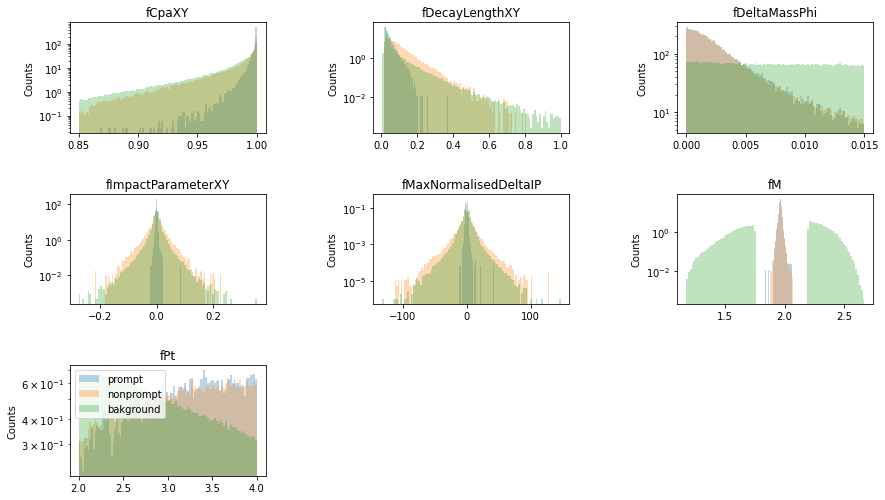

In [7]:
vars_to_draw = ['fCpaXY', 'fDecayLengthXY', 
                'fDeltaMassPhi', 'fImpactParameterXY',
                'fMaxNormalisedDeltaIP', 'fM', 'fPt'] ##just a selection of all the  possible variables
leg_labels = ["prompt", "nonprompt", "bakground"] ## matching the order of the hdl_all

plot_utils.plot_distr(hdl_all, vars_to_draw, bins=100, labels=leg_labels, log=True, density=True, figsize=(12, 7), alpha=0.3, grid=False)
plt.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.96, hspace=0.55, wspace=0.55)
plt.show()

Similarly, the correlation matrix for the features is plotted with the function _plt\_utils_._plot\_corr_.

It is important cross-check that none of the features is strongly related to the invariant mass to avoid biases.

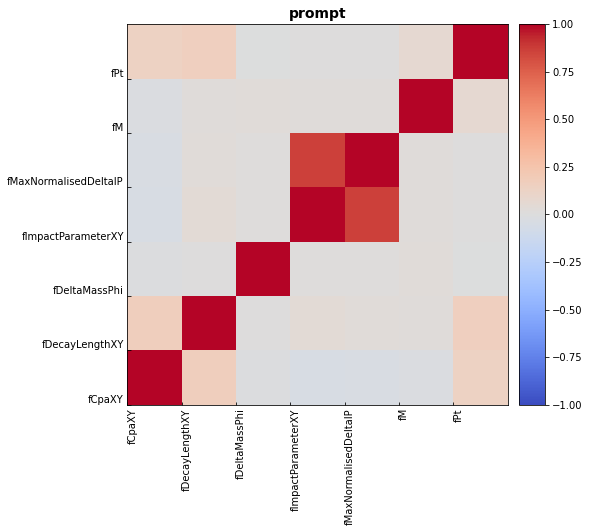

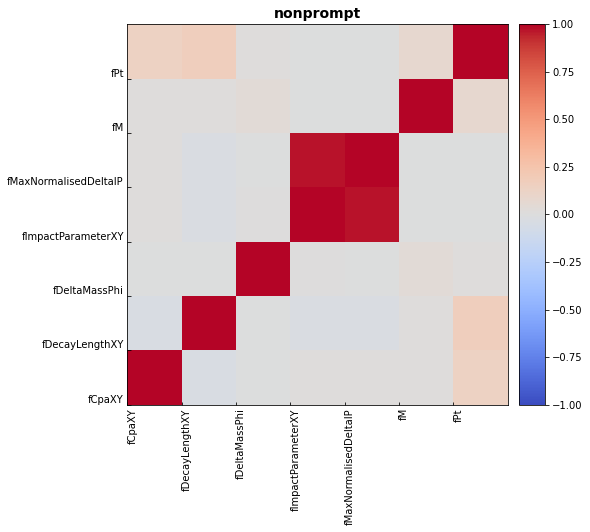

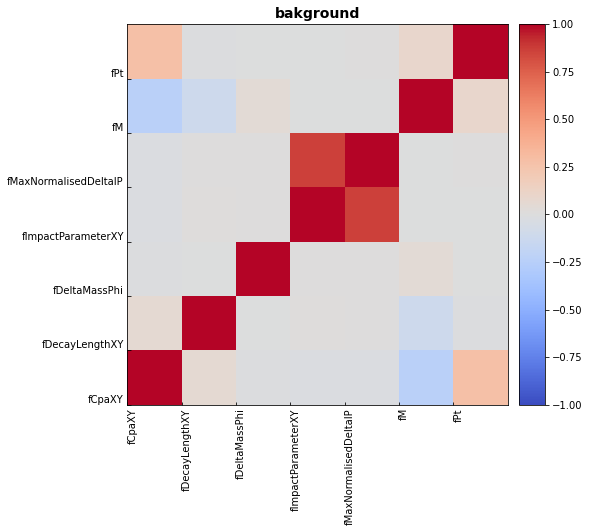

In [8]:
plot_utils.plot_corr(hdl_all, vars_to_draw, leg_labels)
plt.show()

### **The model**

For this tutorial, [_XGBoost_](https://xgboost.readthedocs.io/en/latest/) is used as classification algorithm. XGBoost is an implementation of gradient boosted decision trees, designed to be highly efficient, flexible and portable.

The _hipe4ml_ package deals with the model through the _ModelHandler_ module. The model-handler is used to define the features used in the training process and to set the _hyperparameters_ of the model, such as the number of estimators, the maximum depth of the trees and the learning rate.

Several other implementations are included of the BDT are included in hipe4ml. XGBoost is the one usually employed in the HF analyses. 

Let's initialise the algorithm with the features we want to include in the training.


In [9]:
features_for_train = ['fCpa', 'fCpaXY', 'fDecayLength', 'fDecayLengthXY', 'fDeltaMassPhi', 'fImpactParameterXY', 'fAbsCos3PiK',
                      'fMaxNormalisedDeltaIP'] 

model_params = {'max_depth':5, 'learning_rate':0.029, 'n_estimators':500, 'min_child_weight':2.7, 'subsample':0.90, 'colsample_bytree':0.97, 'n_jobs':1, 'tree_method': 'gpu_hist'}

model_clf = xgb.XGBClassifier()
model_hdl = ModelHandler(model_clf, features_for_train, model_params)

A huge number of features would lead to a large time and CPU consumption. For this reason, we decided to limit the number of variables in the training.

### **Optimisation of hyperparameters with Optuna**
The _hyperparameters_ consist of the internal parameters of the BDT algorithm which are not optimised within the training phase. Few of them are listed here below, for a complete description see the [_XGBoost-Doc_](https://xgboost.readthedocs.io/en/stable/parameter.html)
- _n_estimators_: Number of trees in the BDT
- _max_depth_: Maximum depth of a tree
- _eta_: learning rate of the algorithm. It controls the step size of the gradient descent algorithm

The optimisation of the hyperparameters is a key step to obtain the best performance from the algorithm. In _hipe4ml_ the [Optuna](https://github.com/optuna/optuna) package is employed for the optimisation through the method _ModelHandler.optimize\_params\_optuna_.

The difference between Optuna and other packages dedicated to hyperparametrs optimisation based on grid search or random search is that Optuna takes into account the past hyperparameter configuration evaluations when choosing the configuration to evaluate next.

A set of hyperparameters should be tested on different samples to avoid overfitting problems. Since the number of events is limited, an approach called _k-flod cross validation_ is used. It has been proved that the cross validation removes the dependence of the model on the data sample. 

In the cross validation procedure, the original sample is divided in _k_ parts called _folds_ (in this case 5 folds are used). For each set of hyperparameters, _n-1_ folds are used for the optimisation and the remaining one as test. This operation is repeated after permuting the folds used for optimisation and for testing and the final result is the mean value of all the permutations.

The ModelHandler automatically updates the hyperparameters after their optimisation.

To spare time, in this tutorial the hyperparameter optimisation and the number of configuration was limited.

In [10]:
#hyper_pars_ranges = {"max_depth": (2, 4), "learning_rate": (0.01, 0.1)}
#model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring="roc_auc_ovo", timeout=20.,
#                                 n_trials=1, direction="maximize", save_study='xgb_optuna_study.pkl')
#hyper_pars_opt = {"n_estimators": 1000}

The Optuna study can be saved to be resumed for later analyses, if needed.

### **Training and testing the model**
The model training is performed with the method _train\_test\_model_ of the _ModelHandler_ module. It requires as argument a list containing:
1. the training set;
2. the real class label for the training set;
3. the test set;
4. the real class label for the test set;
5. the multiclass option.

The multi-class option can be set to _ovo_ (i.e._OneVsOne_) or _ovr_ (i.e._OneVeRest_). In the first configuration, for each possible couple of classes a BDT algorithm is trained considering the first class as signal and the second one as background. In the second configuration, for each class a BDT algorithm is trained considering that class as signal and the others as background. In both cases, the final score associated with a candidate is computes as an average of the different BDT scores.

The predictions for the training and the test sets are obtained with the _predict_ method.

In [11]:
model_hdl.train_test_model(train_test_data, multi_class_opt="ovo")

y_pred_train = model_hdl.predict(train_test_data[0], False)
y_pred_test = model_hdl.predict(train_test_data[2], False)

Training xgboost model for classification
Number of detected classes: 3
Training the model: ...


Training the model: Done!
Testing the model: ...
ROC_AUC_score: 0.912068
Testing the model: Done!


The results of the training process can be observed by plotting the distributions of the BDT scores for the training and the test sets. The output consists of a score related to the probability to belong to each of the classes used for the training. This operation is performed with the method _plot\_utils_._plot\_output\_train\_test_.

The distributions of the model scores obtained from the test set are in good agreement with those obtained from the training set. This is a sign that the model has been trained properly.

A disagreement between the distributions obtained from the training set and the datasets would reflect an overfitting by the classification algorithm: the classifier has learnt some characteristics that are peculiar of the training set, but that are not true for a general sample.

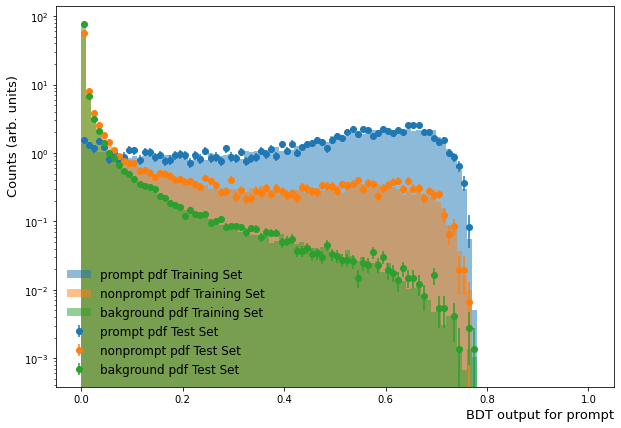

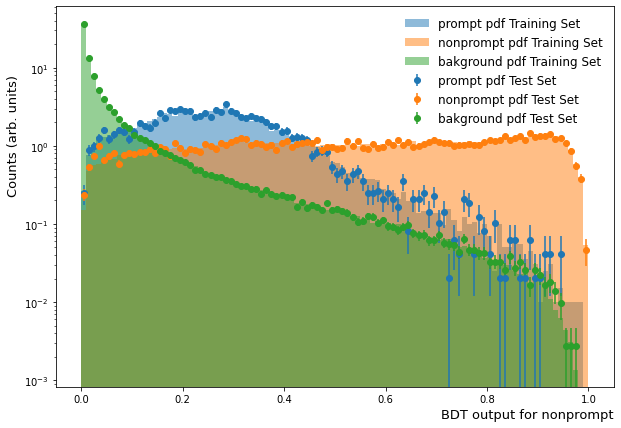

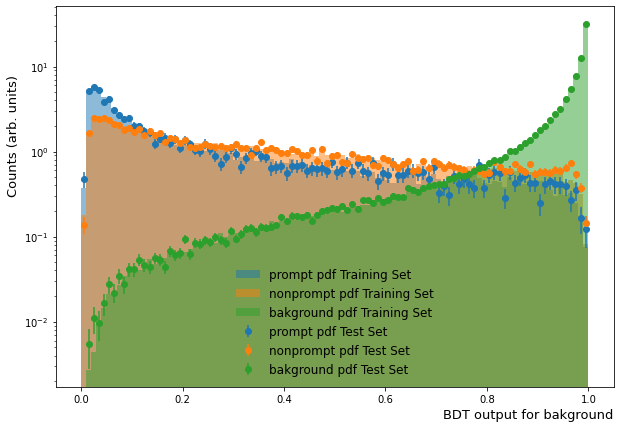

In [12]:
plt.rcParams["figure.figsize"] = (10, 7)

ml_out_fig = plot_utils.plot_output_train_test(model_hdl, train_test_data, 100, 
                                               False, leg_labels, True, density=True)

### **Receiver Operating Curve**
The quality of the algorithm can be also studied with the _ROC curve_. The ROC curve is defined as a function of the _True Positive Rate_ (TPR) against the _False Negative Rate_ (FPR) as a function of a threshold on the BDT score. TPR and FPR are defined as:

$\mathrm{TPR}=\frac{\sum \mathrm{TP}}{\sum \mathrm{TP} + \sum \mathrm{FN}} \hspace{2cm} \mathrm{FPR}=\frac{\sum \mathrm{FP}}{\sum \mathrm{FP} + \sum \mathrm{TN}} $

In the case of multi-classifiaction problems, the ROC curve is not natively defined. Hence, we can either employ the OneVsOne or the OneVs Rest approach. In this tutorial, we adopt the OneVsOne. Therefore, the TPR and the FPR represent the selection efficiency for the first class, considered as signal, and the rejection
efficiency of the second class, considered as background, for each couple of classes, respectively.

The most common way employed to evaluate the performance of a BDT is to compute the _Area Under the Curve_ ROC, called AUC:
- a perfect classifier will have a ROC AUC equal to 1;
- a random classifier will have a ROC AUC equal to 0.5.

A good model classifier is characterised by a large area under the ROC curve (_ROC AUC_).

The ROC curve can be plotted with the method _plot\_utils_._plot\_roc\_train\_test_. 

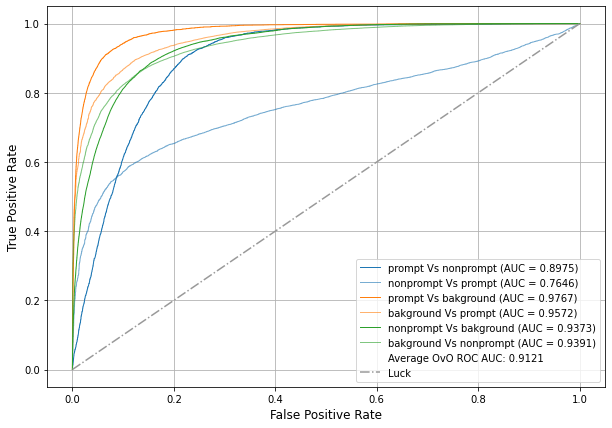

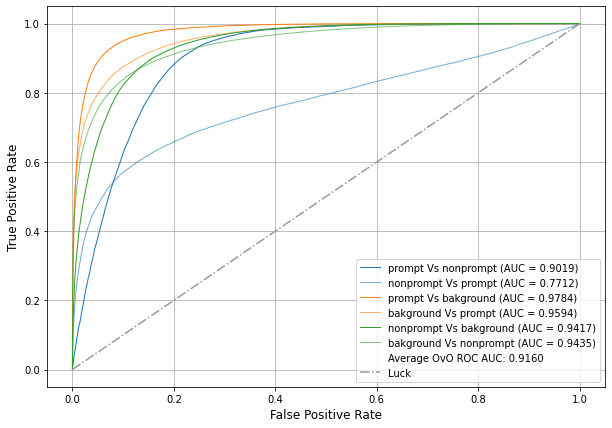

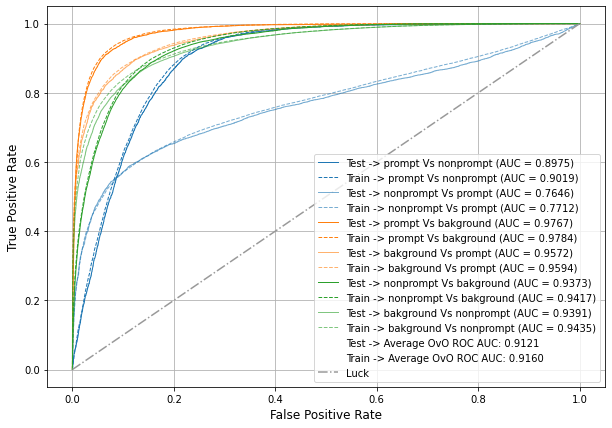

In [13]:
roc_train_test_fig = plot_utils.plot_roc_train_test(train_test_data[3], y_pred_test, train_test_data[1], y_pred_train, None, leg_labels, multi_class_opt="ovo")

Evaluating the ROC AUC in training and test a slight difference is found. The higher ROC AUC in training compared to test is a systematic behaviour due to the small presence of overfitting, which indicates a successful training.

### **Feature Importance**

It is crucial to assess which feature is more important for the BDT to assign its score. This step is twofold. On one hand, understanding which features are the most important to the BDT can help us to interpret the outcome of the algorithm. On the other hand, the feature importance can be used as a cross-check to ensure that the algorithm predilection for
a specific feature is matched by the physics of the problem under study. For instance in the case of D mesons, the most effective features are expected to be the ones associated with the decay length.

The feature importance implemented in the [SHAP](https://github.com/slundberg/shap) library is used in this hands-on session. In the context of machine learning, the _Shapley value_ is used to evaluate the contribution of each feature to the model output, and it is calculated by averaging the marginal contributions of each feature to the model output. The marginal contribution of a feature is the difference in the model output when the feature is present or absent. The variables that are more important for the model are those that have a higher marginal contribution, and Shapley values consequently.

The SHAP feature importance can be plotted with the method _plot\_utils_._plot\_feat\_imp_

In [14]:
#TODO
# 
# plot_utils.plot_feature_imp(train_test_data[2], train_test_data[3], model_hdl) 

### **Visualise the results**



In [ ]:
yPredData = model_hdl.predict(hdl_appl, False)
Dsdf = hdl_appl.get_data_frame()
Dsdf['prompt_score'] = yPredData[:, 0]
Dsdf['nonprompt_score'] = yPredData[:, 1]
Dsdf['background_score'] = yPredData[:, 2]

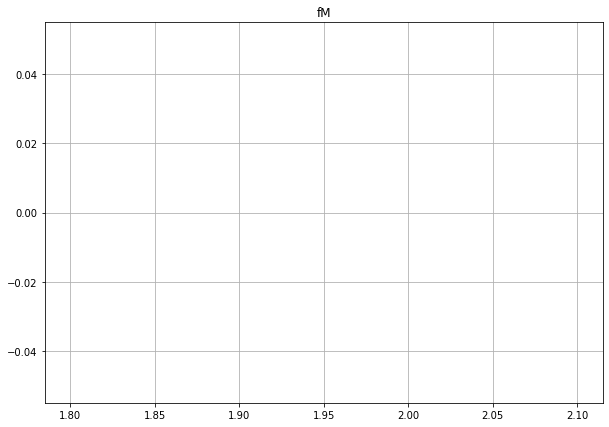

In [18]:
DsPrompt = Dsdf.query('prompt_score > 0.4 and background_score < 0.8')
hist = DsPrompt.hist(column='fM', bins=30, range=(1.8, 2.1))